# Model-free Analysis

The grid search resulted in diverging log likelihoods. Assuming that the loss calculation is correct, a sanity check must be conducted on generated data to demonstrate that it makes empirical conditions.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

# Load and preprocess
df = pd.read_csv('/Users/braydenchien/Desktop/Enkavilab/DDM/formatted_data/sim_trials_s42_d1.2_t0.38_n0.45.csv')

/var/folders/59/03h51wmn6xn1jhvb7kj9fjc40000gn/T/ipykernel_60419/2053392802.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = first_fix_df.groupby('diff_bin')['toward_larger'].agg(['mean', sem]).reset_index()
/var/folders/59/03h51wmn6xn1jhvb7kj9fjc40000gn/T/ipykernel_60419/2053392802.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = middle_fix_df.groupby('diff_bin')['fix_dur'].agg(['mean', sem]).reset_index()
/Users/braydenchien/.pyenv/versions/DDM/lib/python3.12/site-packages/pandas/core/groupby/generic.py:324: SmallSampleWarning: One or more sample arguments is too small; all retur

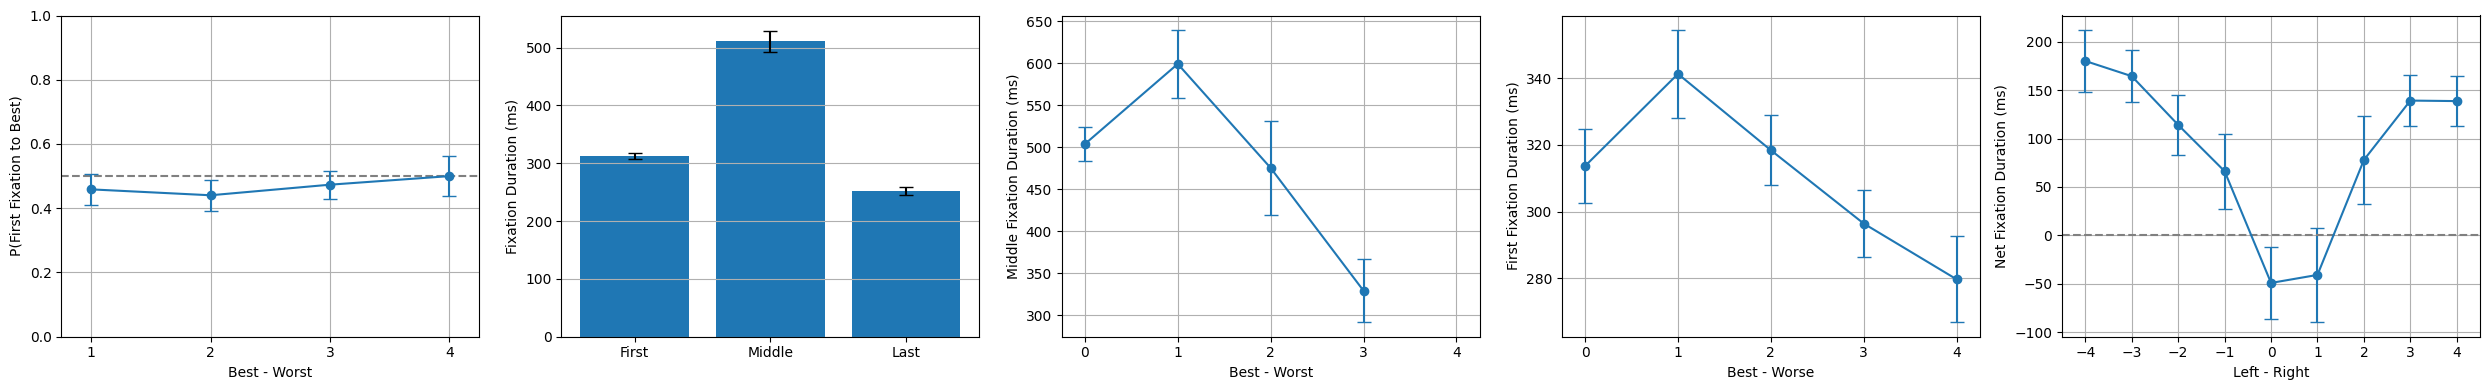

In [10]:
# --------------------------- #
# Figure 1: First 5 plots     #
# --------------------------- #
fig1, axs = plt.subplots(1, 5, figsize=(25, 4))

## Plot 1: First fixation toward higher value
first_fix_df = df[df['fix_num'] == 1].copy()
first_fix_df['abs_diff'] = np.abs(first_fix_df['avgWTP_left'] - first_fix_df['avgWTP_right'])
first_fix_df['larger_side'] = np.where(first_fix_df['avgWTP_left'] > first_fix_df['avgWTP_right'], 1, 2)
first_fix_df['toward_larger'] = first_fix_df['location'] == first_fix_df['larger_side']
first_fix_df['diff_bin'] = pd.cut(first_fix_df['abs_diff'], bins=[0.5, 1.5, 2.5, 3.5, 4.5], labels=[1, 2, 3, 4])
summary = first_fix_df.groupby('diff_bin')['toward_larger'].agg(['mean', sem]).reset_index()
summary.columns = ['diff_bin', 'mean_toward_larger', 'sem_toward_larger']
axs[0].axhline(0.5, color='grey', linestyle='--')
axs[0].errorbar(summary['diff_bin'].astype(int), summary['mean_toward_larger'], yerr=summary['sem_toward_larger'], fmt='o-', capsize=5)
axs[0].set_xlabel('Best - Worst')
axs[0].set_ylabel('P(First Fixation to Best)')
axs[0].set_ylim(0, 1)
axs[0].set_xlim(0.75, 4.25)
axs[0].set_xticks([1, 2, 3, 4])
axs[0].grid(True)

## Plot 2: Fixation duration by type
middle_fix_df = df[(df['fix_num'] != 1) & (df['fix_num_rev'] != 1)].copy()
last_fix_df = df[df['fix_num_rev'] == 1].copy()
means = [first_fix_df['fix_dur'].mean(), middle_fix_df['fix_dur'].mean(), last_fix_df['fix_dur'].mean()]
errors = [sem(first_fix_df['fix_dur']), sem(middle_fix_df['fix_dur']), sem(last_fix_df['fix_dur'])]
axs[1].bar(['First', 'Middle', 'Last'], means, yerr=errors, capsize=5)
axs[1].set_ylabel('Fixation Duration (ms)')
axs[1].grid(axis='y')

## Plot 3: Middle fixation duration by difficulty
middle_fix_df['abs_diff'] = np.abs(middle_fix_df['avgWTP_left'] - middle_fix_df['avgWTP_right'])
middle_fix_df['diff_bin'] = pd.cut(middle_fix_df['abs_diff'], bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5], labels=[0, 1, 2, 3, 4])
summary = middle_fix_df.groupby('diff_bin')['fix_dur'].agg(['mean', sem]).reset_index()
summary.columns = ['difficulty', 'mean_fix_dur', 'sem_fix_dur']
axs[2].errorbar(summary['difficulty'], summary['mean_fix_dur'], yerr=summary['sem_fix_dur'], fmt='o-', capsize=5)
axs[2].set_xlabel('Best - Worst')
axs[2].set_ylabel('Middle Fixation Duration (ms)')
axs[2].set_xticks([0, 1, 2, 3, 4])
axs[2].set_xlim(-0.25, 4.25)
axs[2].grid(True)

## Plot 4: First fixation duration by difficulty
first_fix_df['diff_bin'] = pd.cut(first_fix_df['abs_diff'], bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5], labels=[0, 1, 2, 3, 4])
summary = first_fix_df.groupby('diff_bin')['fix_dur'].agg(['mean', sem]).reset_index()
summary.columns = ['difficulty', 'mean_fix_dur', 'sem_fix_dur']
axs[3].errorbar(summary['difficulty'], summary['mean_fix_dur'], yerr=summary['sem_fix_dur'], fmt='o-', capsize=5)
axs[3].set_xlabel('Best - Worse')
axs[3].set_ylabel('First Fixation Duration (ms)')
axs[3].set_xticks([0, 1, 2, 3, 4])
axs[3].set_xlim(-0.25, 4.25)
axs[3].grid(True)

## Plot 5: Net fixation duration by signed difficulty
df['signed_diff'] = df['avgWTP_left'] - df['avgWTP_right']
df['signed_fix_dur'] = df.apply(lambda row: row['fix_dur'] if row['location'] == 1 else -row['fix_dur'], axis=1)
trial_durations = df.groupby('trial').agg({'signed_fix_dur': 'sum', 'signed_diff': 'first'}).reset_index()
trial_durations['diff_bin'] = pd.cut(trial_durations['signed_diff'], bins=np.arange(-4.5, 5, 1), labels=np.arange(-4, 5))
summary = trial_durations.groupby('diff_bin')['signed_fix_dur'].agg(['mean', sem]).reset_index()
summary.columns = ['diff_bin', 'mean_net_dur', 'sem_net_dur']
summary['bin_x'] = summary['diff_bin'].astype(int)
axs[4].errorbar(summary['bin_x'], summary['mean_net_dur'], yerr=summary['sem_net_dur'], fmt='o-', capsize=5)
axs[4].axhline(0, color='gray', linestyle='--')
axs[4].set_xlabel('Left - Right')
axs[4].set_ylabel('Net Fixation Duration (ms)')
axs[4].set_xticks(np.arange(-4, 5))
axs[4].set_xlim(-4.5, 4.5)
axs[4].grid(True)

fig1.tight_layout()
plt.show()

/var/folders/59/03h51wmn6xn1jhvb7kj9fjc40000gn/T/ipykernel_60419/141582404.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prob_left_by_bin = first_fix_df.groupby('diff_bin')['choice'].apply(lambda x: (x == 0).mean())
/var/folders/59/03h51wmn6xn1jhvb7kj9fjc40000gn/T/ipykernel_60419/141582404.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_centers = first_fix_df.groupby('diff_bin')['signed_diff'].mean()
/var/folders/59/03h51wmn6xn1jhvb7kj9fjc40000gn/T/ipykernel_60419/141582404.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

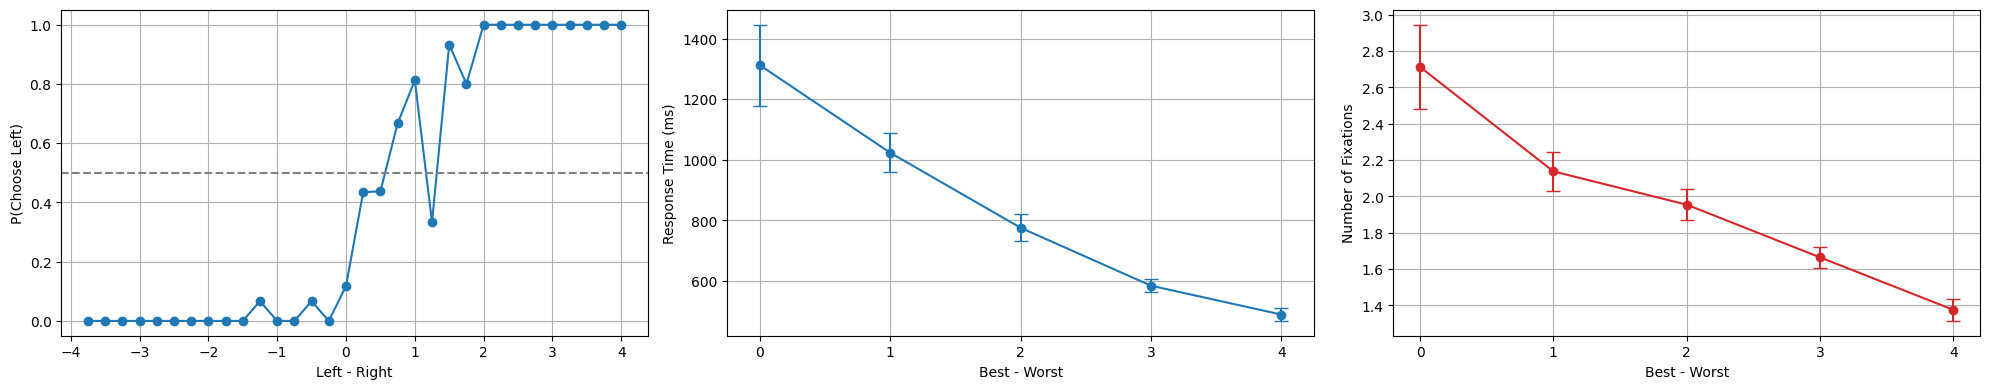

In [11]:
# --------------------------- #
# Figure 2: Last 3 plots      #
# --------------------------- #
fig2, axs = plt.subplots(1, 3, figsize=(20, 4))

## Plot 6: Choice by signed difficulty
first_fix_df['signed_diff'] = first_fix_df['avgWTP_left'] - first_fix_df['avgWTP_right']
first_fix_df['diff_bin'] = pd.cut(first_fix_df['signed_diff'], bins=np.arange(-4, 4.25, 0.25))
prob_left_by_bin = first_fix_df.groupby('diff_bin')['choice'].apply(lambda x: (x == 0).mean())
bin_centers = first_fix_df.groupby('diff_bin')['signed_diff'].mean()
axs[0].plot(bin_centers, prob_left_by_bin, marker='o', linestyle='-')
axs[0].axhline(0.5, color='gray', linestyle='--')
axs[0].set_xlabel("Left - Right")
axs[0].set_ylabel("P(Choose Left)")
axs[0].grid(True)

## Plot 7: Response time by difficulty
first_fix_df['diff_bin'] = pd.cut(first_fix_df['abs_diff'], bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5], labels=[0, 1, 2, 3, 4])
summary = first_fix_df.groupby('diff_bin')['RT'].agg(['mean', sem]).reset_index()
summary.columns = ['diff_bin', 'mean_RT', 'sem_RT']
summary['mean_RT'] *= 1000
summary['sem_RT'] *= 1000
axs[1].errorbar(summary['diff_bin'].astype(int), summary['mean_RT'], yerr=summary['sem_RT'], fmt='o-', capsize=5)
axs[1].set_xlabel("Best - Worst")
axs[1].set_ylabel("Response Time (ms)")
axs[1].set_xticks([0, 1, 2, 3, 4])
axs[1].set_xlim(-0.25, 4.25)
axs[1].grid(True)

## Plot 8: Number of fixations by difficulty
summary = first_fix_df.groupby('diff_bin')['fix_num_rev'].agg(['mean', sem]).reset_index()
summary.columns = ['diff_bin', 'mean_n_fixations', 'sem_n_fixations']
summary['bin_x'] = summary['diff_bin'].astype(float)
axs[2].errorbar(summary['bin_x'], summary['mean_n_fixations'], yerr=summary['sem_n_fixations'], fmt='o-', capsize=5, color='tab:red')
axs[2].set_xlabel("Best - Worst")
axs[2].set_ylabel("Number of Fixations")
axs[2].set_xticks(summary['bin_x'])
axs[2].grid(True)

fig2.tight_layout()
plt.show()
